In [3]:
%load_ext watermark
%watermark -a 'TianchangLi' -v -p matplotlib,torch,pandas,numpy,PIL,cuda

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Author: TianchangLi

Python implementation: CPython
Python version       : 3.8.5
IPython version      : 7.19.0

matplotlib: 3.3.2
torch     : 1.7.1
pandas    : 1.1.3
numpy     : 1.19.2
PIL       : 8.0.1
cuda      : not installed



## Prepare for train, valid, test sets, and images

In [4]:
import pandas as pd
from string import ascii_uppercase


# folder_dict = {'cr':1210, 'gg':296, 'in':775, 'pa':1148, 'ps':797, 'rp':200, 'rs':1589, 'sc':773, 'sp':438}
defect_types = ['Cr', 'In', 'Pa', 'PS', 'RS', 'Sc']
y_train = []
image = []
for i, defect_type in enumerate(defect_types):
    for idx in range(1,301):
        y_train.append(i)
        image.append(f"{defect_type}_{idx}.bmp")

df_train = pd.DataFrame(y_train, columns=['class_label'])
df_train['image_name'] = image
df_train.head()

,class_label,image_name
0,0,Cr_1.bmp
1,0,Cr_2.bmp
2,0,Cr_3.bmp
3,0,Cr_4.bmp
4,0,Cr_5.bmp


In [5]:
df_shuffled = df_train.sample(n=df_train.shape[0], random_state=123)   # 87029 iamges in total
df_trainset = df_shuffled.iloc[:1261]  # 70% test
df_validset = df_shuffled.iloc[1261:1621]  # 20% valid - 17406
df_testset = df_shuffled.iloc[1621:]  # 10% test - 8702
df_testset.tail()

,class_label,image_name
1122,3,PS_223.bmp
1346,4,RS_147.bmp
1406,4,RS_207.bmp
1389,4,RS_190.bmp
1534,5,Sc_35.bmp


In [6]:
df_trainset.to_csv('train.csv', index=None)
df_validset.to_csv('valid.csv', index=None)
df_testset.to_csv('test.csv', index=None)

## Unzipping file

In [37]:
# this code cell unzips the .gz files

# import sys
# import gzip
# import shutil
# import os
# from zipfile import ZipFile

# writemode = 'wb'

# # Create a ZipFile Object and load sample.zip in it

# with ZipFile('asl_alphabet_train.zip', 'r') as zipObj:
#    # Extract all the contents of zip file in current directory
#    zipObj.extractall()

## Load example dataset

In [13]:
import torch
import time
import numpy as np
import pandas as pd
from PIL import Image
import random
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import os
import imageio
import matplotlib.pyplot as plt
%matplotlib inline

#######################################
### PRE-TRAINED MODELS AVAILABLE HERE
## https://pytorch.org/docs/stable/torchvision/models.html
from torchvision import models
#######################################

if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

In [8]:
##############################
### Basic Parameter SETTINGS
##############################

# Device
DEVICE = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
print('Device:', DEVICE)

# Hyperparameters
RANDOM_SEED = 233
LEARNING_RATE = 0.01
NUM_EPOCHS = 10
BATCH_SIZE = 256

# Architecture
NUM_CLASSES = 6

Device: cpu


In [17]:
class ASLDataset(Dataset):
    """Custom Dataset for loading ASL images"""

    def __init__(self, csv_path, img_dir, transform=None):
    
        df = pd.read_csv(csv_path)
        self.img_names = df['image_name'].values
        self.y = df['class_label'].values
        self.img_dir = img_dir

        # convert to np array
#         df_np = df.to_numpy()
#         self.img_names = df_np[:,1]
#         self.y = df_np[:,0]
#         for i in df['class_label'].values:
#             if len(i)==1:
#                 self.y.append(ord(i.lower())-96)
#             elif i=='del':
#                 self.y.append(27)
#             elif i=='nothing':
#                 self.y.append(28)
#             elif i=='space':
#                 self.y.append(29)
#         self.y = np.asarray(self.y)
            
        self.transform = transform
        
    def __getitem__(self, index):
#         img = Image.open(os.path.join(self.img_dir,
#                                       self.img_names[index]))
    #### Read bmp file with os
    ## flatten=0 if image is required as it is 
    ## flatten=1 to flatten the color layers into a single gray-scale layer
        img = imageio.imread(os.path.join(self.img_dir,self.img_names[index]))
        
        if self.transform is not None:
            img = self.transform(img)
        
        label = self.y[index]
        return img, label

    def __len__(self):
        return self.y.shape[0]
    

custom_train_transform = transforms.ToTensor()

custom_test_transform = transforms.ToTensor()

In [18]:
train_dataset = ASLDataset(csv_path='train.csv',
                                    img_dir='NEU-CLS/',
                                    transform=custom_train_transform)

train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True,
                          drop_last=True)

valid_dataset = ASLDataset(csv_path='valid.csv',
                                    img_dir='NEU-CLS/',
                                    transform=custom_test_transform)

valid_loader = DataLoader(dataset=valid_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=False)

test_dataset = ASLDataset(csv_path='test.csv',
                                   img_dir='NEU-CLS/',
                                   transform=custom_test_transform)

test_loader = DataLoader(dataset=test_dataset,
                         batch_size=BATCH_SIZE,
                         shuffle=False)

In [19]:
train_mean = []
train_std = []

for i, image in enumerate(train_loader,):
    numpy_image = image[0].numpy()
    
    batch_mean = np.mean(numpy_image, axis=(0, 2, 3))
    batch_std = np.std(numpy_image, axis=(0, 2, 3))
    
    train_mean.append(batch_mean)
    train_std.append(batch_std)

train_mean = torch.tensor(np.mean(train_mean, axis=0))
train_std = torch.tensor(np.mean(train_std, axis=0))

print('Mean:', train_mean)
print('Std Dev:', train_std)

Mean: tensor([0.5079])
Std Dev: tensor([0.2121])


In [20]:
############### carried over from previous calculation ##################
# train_mean = torch.tensor([0.5079])
# train_std = torch.tensor([0.2121])
#########################################################################
custom_train_transform = transforms.Compose([transforms.ToTensor(),
                                            transforms.Normalize(mean=train_mean, std=train_std)
                                            ])

custom_test_transform = transforms.Compose([transforms.ToTensor(),
                                           transforms.Normalize(mean=train_mean, std=train_std)
                                           ])

train_dataset = ASLDataset(csv_path='train.csv',
                                    img_dir='NEU-CLS/',
                                    transform=custom_train_transform)

train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True,
                          drop_last=True)

valid_dataset = ASLDataset(csv_path='valid.csv',
                                    img_dir='NEU-CLS/',
                                    transform=custom_test_transform)

valid_loader = DataLoader(dataset=valid_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=False)

test_dataset = ASLDataset(csv_path='test.csv',
                                   img_dir='NEU-CLS/',
                                   transform=custom_test_transform)

test_loader = DataLoader(dataset=test_dataset,
                         batch_size=BATCH_SIZE,
                         shuffle=False)

Image batch dimensions: torch.Size([256, 1, 200, 200])
Image label dimensions: 256
Image batch dimensions: torch.Size([256, 1, 200, 200])
Image label dimensions: 256
Image batch dimensions: torch.Size([179, 1, 200, 200])
Image label dimensions: 179


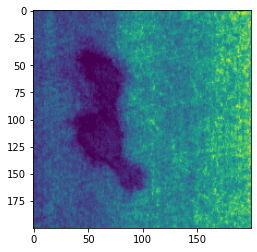

In [29]:
# Checking the dataset
for images, labels in train_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', len(labels))  # Tuple
    break
    
for images, labels in valid_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', len(labels))
    plt.imshow(images[1,0,:,:]);
#     plt.savefig('Figures/Example4_randomCrop')
    break
    
for images, labels in test_loader:      
    print('Image batch dimensions:', images.size())
    print('Image label dimensions:', len(labels))
    break

## Load pre-trained ResNet18

In [30]:
import torchvision.models as models
model = models.resnet18(pretrained=True)
model
# model.load.state_dict(torch.load('Model/ResNet/model_18epoch_0.1lr_0.95ExpDecay_0421.pt'))

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to C:\Users\Evan/.cache\torch\hub\checkpoints\resnet18-5c106cde.pth


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## Freezing the Model

In [37]:
for param in model.parameters():
    param.requires_grad = False
## Modify the first layer to accept grayscale images
model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)    

model.fc.requires_grad = True
model.fc = nn.Sequential(
#     nn.Dropout(0.05),
    nn.Linear(512, NUM_CLASSES)
)

## Training

In [38]:
model = model.to(DEVICE)
optimizer = torch.optim.Adam(model.parameters())
# scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.85, last_epoch=-1)
###### Try 0.01, gamma = 0.95 ############
for param_group in optimizer.param_groups:
    param_group['lr'] = LEARNING_RATE
    print(param_group['lr'])


0.01


In [39]:
# # Display decayed learning rate
# for i in range(8):
#     for param_group in optimizer.param_groups:
#         print(param_group['lr'])
#     scheduler.step()

In [40]:
def compute_accuracy_and_loss(model, data_loader, device):
    correct_pred, num_examples = 0, 0
    cross_entropy = 0.
    for i, (features, targets) in enumerate(data_loader):
            
        features = features.to(device)
        targets = targets.to(device)

        logits = model(features)
        cross_entropy += F.cross_entropy(logits, targets).item()
        _, predicted_labels = torch.max(logits, 1)
        num_examples += targets.size(0)
        correct_pred += (predicted_labels == targets).sum()
    return correct_pred.float()/num_examples * 100, cross_entropy/num_examples
    

start_time = time.time()

# use random seed for reproducibility (here batch shuffling)
torch.manual_seed(RANDOM_SEED)
# NUM_EPOCHS = 1 ############################################## test ###############################

train_acc_lst, valid_acc_lst = [], []
train_loss_lst, valid_loss_lst = [], []

for epoch in range(NUM_EPOCHS):
    
    model.train()
    
    for batch_idx, (features, targets) in enumerate(train_loader):
    
        ### PREPARE MINIBATCH
        features = features.to(DEVICE)
        targets = targets.to(DEVICE)
            
        ### FORWARD AND BACK PROP
        logits = model(features)
        
#         if batch_idx == 1:
#             print("logits:", logits, "targets:", targets)
#             print("logits shape:", logits.shape, "targets shape:", targets.shape, "targets type", targets.dtype)
#             break
            
        cost = F.cross_entropy(logits, targets)
        optimizer.zero_grad()
        
        cost.backward()
        
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        ### LOGGING
        if not batch_idx % 120:
            print (f'Epoch: {epoch+1:03d}/{NUM_EPOCHS:03d} | '
                   f'Batch {batch_idx:03d}/{len(train_loader):03d} |' 
                   f' Cost: {cost:.4f}')
    
    ################ Doesn't have to update each epoch ###################
#     if (not epoch % 4) & (epoch > 1):
#         scheduler.step()
    ######################################################################

    # no need to build the computation graph for backprop when computing accuracy
    with torch.set_grad_enabled(False):
        train_acc, train_loss = compute_accuracy_and_loss(model, train_loader, device=DEVICE)
        valid_acc, valid_loss = compute_accuracy_and_loss(model, valid_loader, device=DEVICE)
        train_acc_lst.append(train_acc)
        valid_acc_lst.append(valid_acc)
        train_loss_lst.append(train_loss)
        valid_loss_lst.append(valid_loss)
        print(f'Epoch: {epoch+1:03d}/{NUM_EPOCHS:03d} Train Acc.: {train_acc:.2f}%'
              f' | Validation Acc.: {valid_acc:.2f}%')
        
    elapsed = (time.time() - start_time)/60
    print(f'Time elapsed: {elapsed:.2f} min')
    
#     for param_group in optimizer.param_groups:
#         print('Learning rate:', param_group['lr'])
    
elapsed = (time.time() - start_time)/60
print(f'Total Training Time: {elapsed:.2f} min')

Epoch: 001/010 | Batch 000/004 | Cost: 1.8737
Epoch: 001/010 Train Acc.: 43.95% | Validation Acc.: 39.17%
Time elapsed: 1.00 min
Epoch: 002/010 | Batch 000/004 | Cost: 1.5423
Epoch: 002/010 Train Acc.: 54.98% | Validation Acc.: 55.28%
Time elapsed: 1.99 min
Epoch: 003/010 | Batch 000/004 | Cost: 1.2784
Epoch: 003/010 Train Acc.: 76.17% | Validation Acc.: 80.00%
Time elapsed: 2.97 min
Epoch: 004/010 | Batch 000/004 | Cost: 0.6365
Epoch: 004/010 Train Acc.: 75.98% | Validation Acc.: 78.06%
Time elapsed: 3.95 min
Epoch: 005/010 | Batch 000/004 | Cost: 0.7063
Epoch: 005/010 Train Acc.: 87.70% | Validation Acc.: 85.28%
Time elapsed: 5.07 min
Epoch: 006/010 | Batch 000/004 | Cost: 0.3865
Epoch: 006/010 Train Acc.: 86.91% | Validation Acc.: 90.00%
Time elapsed: 6.06 min
Epoch: 007/010 | Batch 000/004 | Cost: 0.3469
Epoch: 007/010 Train Acc.: 90.23% | Validation Acc.: 91.39%
Time elapsed: 7.04 min
Epoch: 008/010 | Batch 000/004 | Cost: 0.2671
Epoch: 008/010 Train Acc.: 92.09% | Validation Acc.

In [41]:
torch.save(model.state_dict(), 'Model/ResNet/model_10epoch.pt')
torch.save(optimizer.state_dict(), 'Model/ResNet/optimizer_10epoch.pt')
# torch.save(scheduler.state_dict(), 'Model/ResNet/scheduler_20epoch_0.0012lr_0.85Decay_every4_0.05dropout.pt')

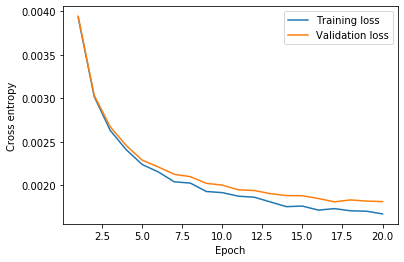

In [12]:
fig = plt.figure()
ax = plt.subplot(111)
ax.plot(range(1, NUM_EPOCHS+1), train_loss_lst, label='Training loss')
ax.plot(range(1, NUM_EPOCHS+1), valid_loss_lst, label='Validation loss')
ax.legend(loc='upper right')
plt.ylabel('Cross entropy')
plt.xlabel('Epoch')
plt.show()
fig.savefig('Figures/Loss_20epoch_randomCrop.png')

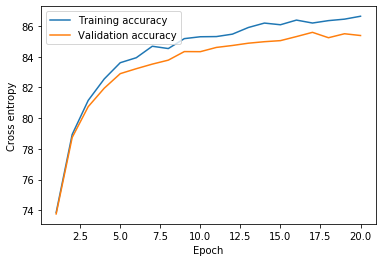

In [13]:
fig = plt.figure()
ax = plt.subplot(111)
ax.plot(range(1, NUM_EPOCHS+1), train_acc_lst, label='Training accuracy')
ax.plot(range(1, NUM_EPOCHS+1), valid_acc_lst, label='Validation accuracy')
ax.legend(loc='upper left')
plt.ylabel('Cross entropy')
plt.xlabel('Epoch')
plt.show()
fig.savefig('Figures/Acc_20epoch_randomCrop.png')

In [17]:
with torch.set_grad_enabled(False): # save memory during inference
    print('Test accuracy: %.2f%%' % (compute_accuracy_and_loss(model, test_loader, device=DEVICE)[0]))

Test accuracy: 85.19%
